#### Overfitting and Underfitting

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2023-12-17 22:08:51.259124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 22:08:51.290199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 22:08:51.290223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 22:08:51.291209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 22:08:51.297160: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fuwmepnm
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fuwmepnm
  Resolved https://github.com/tensorflow/docs to commit fa06aeec62124aa76f4cf7e80172be3e925ef252
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.5 MB/s eta 0:00:00
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.12.6.69331-py3-none-any.whl size=181264 sha256=a465f921a1e7243353071b51fae0c2df79fb0f746a656f3a192124bac166d550
  Stored in di

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

#### Higgs dataset
- Particle physics data with 28 feature labels and a binary class

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 431s 0us/step


In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

2023-12-17 22:58:49.509126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 22:58:49.538198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 22:58:49.538234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 22:58:49.541833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 22:58:49.541878: I external/local_xla/xla/stream_executor

In [9]:
def pack_row(*row): # repacks list of scalars into (feature, label) pairs
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label
packed_ds = ds.batch(10000).map(pack_row).unbatch() # Tf is faster in batches.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


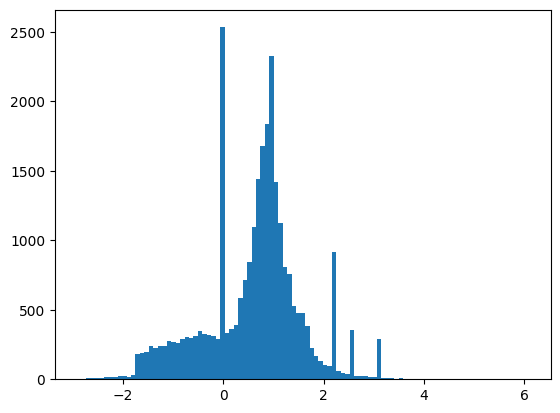

In [11]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [13]:
# Use a small subsample of the data

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [14]:
# Cache data so the laoder doesn't need to re-read data from the file on each epoch
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.take(N_TRAIN).cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

#### Overfitting
- Start with a simple model of densely connected layers as a baseline and increase complexity
- Learning Rate Schedule: `tf.keras.optimizers.schedules.InverseTimeDecay`

In [15]:
# Reduce learning rate with time
# Hyperbollically decrease the learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

Text(0, 0.5, 'Learning Rate')

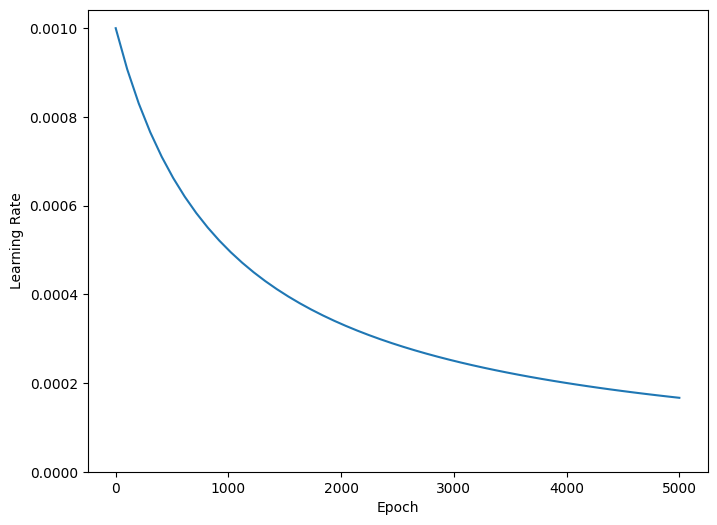

In [16]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [21]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(), # Reduce logging noise
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), # Early Stopping
        tf.keras.callbacks.TensorBoard(logdir/name), # Generate Tensorboard logs
    ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics = [
                      tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                      'accuracy'
                  ])
    
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )
    return history

In [19]:
# Tiny model
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-17 23:51:13.637492: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 23:51:17.210640: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2cc44c79f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 23:51:17.210676: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-17 23:51:17.216169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-17 23:51:17.234219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702885877.298519  421694 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch: 0, accuracy:0.4804,  binary_crossentropy:0.9586,  loss:0.9586,  val_accuracy:0.5010,  val_binary_crossentropy:0.8735,  val_loss:0.8735,  
..

2023-12-17 23:51:20.245243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10550338802865363226
2023-12-17 23:51:20.245318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12811049799601669728


..................................................................................................
Epoch: 100, accuracy:0.5949,  binary_crossentropy:0.6262,  loss:0.6262,  val_accuracy:0.5870,  val_binary_crossentropy:0.6161,  val_loss:0.6161,  
....................................................................................................
Epoch: 200, accuracy:0.6236,  binary_crossentropy:0.6134,  loss:0.6134,  val_accuracy:0.6210,  val_binary_crossentropy:0.5981,  val_loss:0.5981,  
....................................................................................................
Epoch: 300, accuracy:0.6343,  binary_crossentropy:0.6025,  loss:0.6025,  val_accuracy:0.6420,  val_binary_crossentropy:0.5854,  val_loss:0.5854,  
....................................................................................................
Epoch: 400, accuracy:0.6539,  binary_crossentropy:0.5936,  loss:0.5936,  val_accuracy:0.6640,  val_binary_crossentropy:0.5732,  val_loss:0.5732,  
..........

(0.5, 0.7)

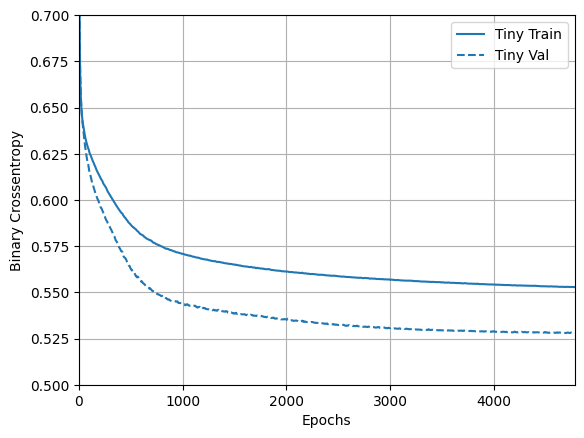

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [24]:
# Small model
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4828,  binary_crossentropy:0.7730,  loss:0.7730,  val_accuracy:0.4880,  val_binary_crossentropy:0.7281,  val_loss:0.7281,  
..

2023-12-18 00:07:55.694025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10550338802865363226
2023-12-18 00:07:55.694129: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6990682822528571160


..................................................................................................
Epoch: 100, accuracy:0.6431,  binary_crossentropy:0.6014,  loss:0.6014,  val_accuracy:0.6500,  val_binary_crossentropy:0.5815,  val_loss:0.5815,  
....................................................................................................
Epoch: 200, accuracy:0.6721,  binary_crossentropy:0.5826,  loss:0.5826,  val_accuracy:0.6990,  val_binary_crossentropy:0.5562,  val_loss:0.5562,  
....................................................................................................
Epoch: 300, accuracy:0.6784,  binary_crossentropy:0.5729,  loss:0.5729,  val_accuracy:0.6840,  val_binary_crossentropy:0.5472,  val_loss:0.5472,  
....................................................................................................
Epoch: 400, accuracy:0.6809,  binary_crossentropy:0.5677,  loss:0.5677,  val_accuracy:0.7180,  val_binary_crossentropy:0.5439,  val_loss:0.5439,  
..........

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium'] = compile_and_fit(small_model, 'sizes/Medium')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.7203,  binary_crossentropy:0.5294,  loss:0.5294,  val_accuracy:0.7470,  val_binary_crossentropy:0.4988,  val_loss:0.4988,  
..

2023-12-18 00:17:51.027997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10550338802865363226
2023-12-18 00:17:51.028066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6990682822528571160


..................................................................................................
Epoch: 100, accuracy:0.7223,  binary_crossentropy:0.5249,  loss:0.5249,  val_accuracy:0.7540,  val_binary_crossentropy:0.4969,  val_loss:0.4969,  
....................................................................................................
Epoch: 200, accuracy:0.7239,  binary_crossentropy:0.5235,  loss:0.5235,  val_accuracy:0.7580,  val_binary_crossentropy:0.4980,  val_loss:0.4980,  
....................................................................................................
Epoch: 300, accuracy:0.7234,  binary_crossentropy:0.5211,  loss:0.5211,  val_accuracy:0.7540,  val_binary_crossentropy:0.4962,  val_loss:0.4962,  
....................................................................................................
Epoch: 400, accuracy:0.7236,  binary_crossentropy:0.5212,  loss:0.5212,  val_accuracy:0.7400,  val_binary_crossentropy:0.5012,  val_loss:0.5012,  
..........

In [26]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['Large'] = compile_and_fit(small_model, 'sizes/Large')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.7266,  binary_crossentropy:0.5182,  loss:0.5182,  val_accuracy:0.7360,  val_binary_crossentropy:0.4977,  val_loss:0.4977,  
.

2023-12-18 00:20:53.812618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10550338802865363226
2023-12-18 00:20:53.812689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6990682822528571160


...................................................................................................
Epoch: 100, accuracy:0.7286,  binary_crossentropy:0.5149,  loss:0.5149,  val_accuracy:0.7660,  val_binary_crossentropy:0.4920,  val_loss:0.4920,  
....................................................................................................
Epoch: 200, accuracy:0.7284,  binary_crossentropy:0.5137,  loss:0.5137,  val_accuracy:0.7510,  val_binary_crossentropy:0.4933,  val_loss:0.4933,  
....................................................................................................
Epoch: 300, accuracy:0.7295,  binary_crossentropy:0.5131,  loss:0.5131,  val_accuracy:0.7620,  val_binary_crossentropy:0.4906,  val_loss:0.4906,  
....................................................................................................
Epoch: 400, accuracy:0.7330,  binary_crossentropy:0.5136,  loss:0.5136,  val_accuracy:0.7590,  val_binary_crossentropy:0.4904,  val_loss:0.4904,  
.........

Text(0.5, 0, 'Epochs [Log Scale]')

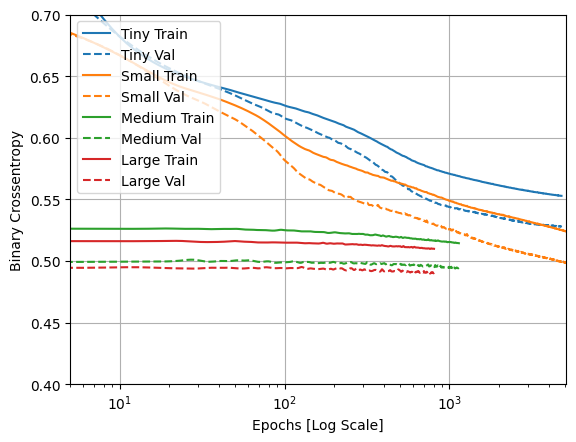

In [27]:
# Plot model losses under a log scale
# Doesn't quite match the tutorial, there's no overfitting here lol
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.4, 0.7])
plt.xlabel('Epochs [Log Scale]')

In [28]:
%load_ext tensorboard
%tensorboard --logdir {logdir}/sizes

#### Preventing Overfitting
- Dropout
- Regularization
    - L1: pushes weights towards exactly 0, encouraging a sparse model
    - L2: also called weight decay, pushes weights close to 0, discouraging sparse models

In [29]:
# Keep Tiny as a baseline
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp6t3022oc/tensorboard_logs/regularizers/Tiny')

In [30]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [31]:
# Like the large mode, but with L2 regularization
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

2023-12-18 00:43:13.800240: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4860421463786183943
2023-12-18 00:43:13.800319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7042502983386907548


...................................................................................................
Epoch: 100, accuracy:0.6667,  binary_crossentropy:0.5901,  loss:0.6161,  val_accuracy:0.6960,  val_binary_crossentropy:0.5580,  val_loss:0.5842,  
....................................................................................................
Epoch: 200, accuracy:0.6811,  binary_crossentropy:0.5777,  loss:0.6020,  val_accuracy:0.6960,  val_binary_crossentropy:0.5413,  val_loss:0.5654,  
....................................................................................................
Epoch: 300, accuracy:0.6854,  binary_crossentropy:0.5734,  loss:0.5979,  val_accuracy:0.6970,  val_binary_crossentropy:0.5373,  val_loss:0.5623,  
....................................................................................................
Epoch: 400, accuracy:0.6900,  binary_crossentropy:0.5623,  loss:0.5887,  val_accuracy:0.7290,  val_binary_crossentropy:0.5322,  val_loss:0.5585,  
.........

(0.3, 0.7)

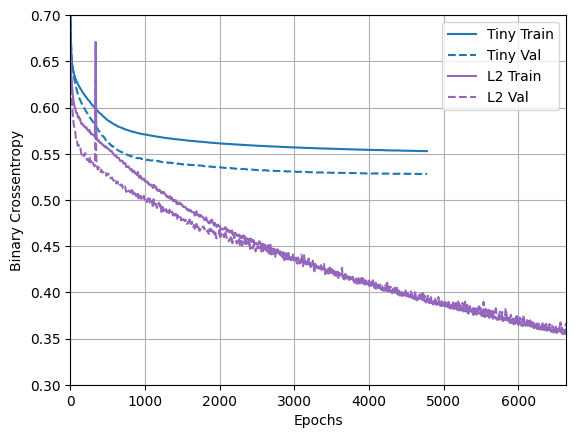

In [33]:
plotter.plot(regularizer_histories)
plt.ylim([0.3, 0.7])

In [34]:
# I don't get this part. If I'm writing my own training loop?
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

# Used for "decoupled weight decay" like Ftrl and AdamW

In [38]:
# Dropout
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               14848     
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)              

2023-12-18 01:06:38.281074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2539778575738579461
2023-12-18 01:06:38.281162: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1164305570403948590


...................................................................................................
Epoch: 100, accuracy:0.6601,  binary_crossentropy:0.5924,  loss:0.5924,  val_accuracy:0.6950,  val_binary_crossentropy:0.5432,  val_loss:0.5432,  
....................................................................................................
Epoch: 200, accuracy:0.6915,  binary_crossentropy:0.5540,  loss:0.5540,  val_accuracy:0.7460,  val_binary_crossentropy:0.4864,  val_loss:0.4864,  
....................................................................................................
Epoch: 300, accuracy:0.7250,  binary_crossentropy:0.5083,  loss:0.5083,  val_accuracy:0.7670,  val_binary_crossentropy:0.4294,  val_loss:0.4294,  
....................................................................................................
Epoch: 400, accuracy:0.7557,  binary_crossentropy:0.4655,  loss:0.4655,  val_accuracy:0.8540,  val_binary_crossentropy:0.3341,  val_loss:0.3341,  
.........

(0.0, 0.7)

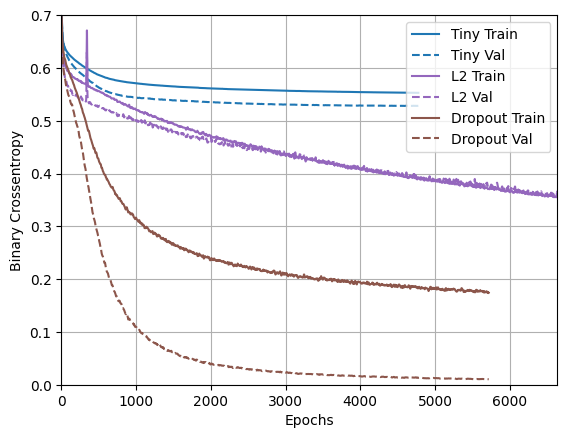

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0, 0.7])

In [45]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1)
])
regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 512)               14848     
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 512)               262656    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_51 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 512)             

2023-12-18 01:21:51.578762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4860421463786183943
2023-12-18 01:21:51.578864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7042502983386907548


..................................................................................................
Epoch: 100, accuracy:0.5768,  binary_crossentropy:0.6386,  loss:0.6497,  val_accuracy:0.5730,  val_binary_crossentropy:0.6187,  val_loss:0.6299,  
....................................................................................................
Epoch: 200, accuracy:0.5889,  binary_crossentropy:0.6351,  loss:0.6458,  val_accuracy:0.5480,  val_binary_crossentropy:0.6231,  val_loss:0.6338,  
....................................................................................................
Epoch: 300, accuracy:0.5861,  binary_crossentropy:0.6321,  loss:0.6443,  val_accuracy:0.5950,  val_binary_crossentropy:0.6108,  val_loss:0.6232,  
....................................................................................................
Epoch: 400, accuracy:0.6197,  binary_crossentropy:0.6182,  loss:0.6348,  val_accuracy:0.6080,  val_binary_crossentropy:0.5944,  val_loss:0.6112,  
..........

(0.0, 0.7)

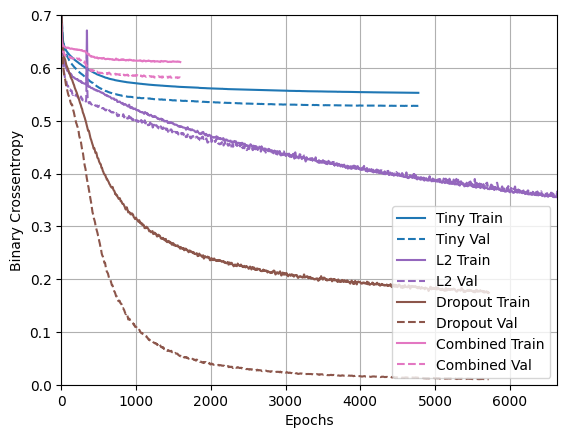

In [46]:
plotter.plot(regularizer_histories)
plt.ylim([0, 0.7])

In [47]:
%tensorboard --logdir {logdir}/regularizers

Reusing TensorBoard on port 6007 (pid 1525684), started 0:05:44 ago. (Use '!kill 1525684' to kill it.)

In [ ]:
# Other methods not mentioned are Data augmentation and Batch Normalization